### What Makes ML Interesting

- Normally a programmer writes explicit rules a program follows

    - This works for things we have the ability to conceptualize

    - However, this becomes more difficult as complexity increases

        - Write a program that...

            - identifies if an image is of a human face

            - accuratly captions an image


- ML models start from an essentially random state

    - They learn over time

    - They don't require input from a programmer once trained
<br></br>






### Machine Learning Paradigms

- Supervised learning
- Unsupervised learning
- Reinforcement learning



### Supervised Learning

- Predict something given some data

### Inputs  

- Data you want to learn a representation of

- Input data commonly resembles a spread sheet
    - Each row, a single input to our model
    
    - An input (or sample) is composed of a set of features
        - Each distinct feature gets its own column in the sheet
   


### Targets

- What are we trying to predict?

- A target represents the ideal output of a model for a given sample
- Sometimes stored as the last column in a sheet

<br/> 
<br/> 

| Height | Weight | Gender | Age | Smokes | % chance of developing heart disease over next yr |
| --- | --- | --- | --- | --- | --- |
| 71 | 165 | 1 | 27 | 1 | 0.170 |
| 64 | 137 | 0 | 41 | 0 | 0.053 |

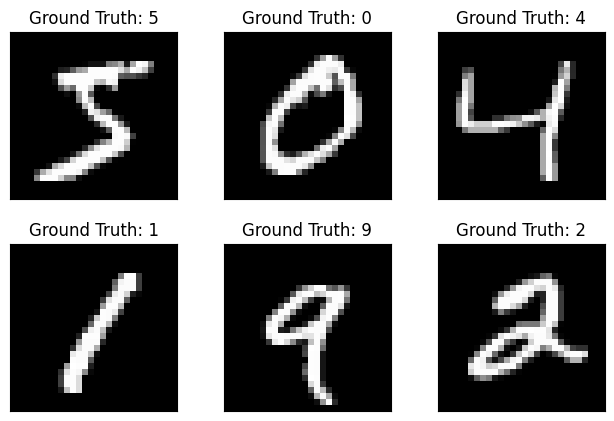

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnistDataset = datasets.MNIST('./data', train=True, download=True, 
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        (0.1307,), # Mean
                                        (0.3081,)  # std.
                                        )
                                ]))

mnistExample = DataLoader(mnistDataset, batch_size=6)
batchIdx, (exampleData, exampleTargets) = next(enumerate(mnistExample))

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(exampleTargets[i]))
    plt.xticks([])
    plt.yticks([])

### Dataset Symbols

- $N$ number of samples
- $M$ number of features
- $x_i$ a single input
    - $x_i$ is a vector of features of `length(M)`
    <br></br>
- $y_i$ target output for $x_i$
    - Ground truth label  
    <br></br>
- $\hat{y_i}$ output of our model for input $x_i$

### Representations

- The goal of our model (NN) is to learn a representation of $f$ such that $ f(x) = y $
    - Especially for $(x,y)$ pairs outside our training data
<br></br>
- The actual output of our model: $f(x) = \hat{y}$

- Realistically:
    - We want to minimize the error between our outputs $(\hat{y})$ and targets $(y)$ over all such pairs

### Classification vs. Regression

- Regression problems involve continuous ouputs instead of a discreet set

- Classification problems involve a discreet number of possible outputs
- Neural networks dont do well using a single output $\hat{y} \in \mathbb{R}$ for clasification problems
    - Targets are usually encoded as one-hot vectors for classification
    
<br></br>
<img src="images/regression_vs_classification.png" width="650">

### One-hot encoding

- Our handwritten digit problem is a classification problem with $10$ discreet possible classes
    - Instead of one number, we use 10 probabilities
<br></br>
- One-hot example $y = 2$ 
    - $y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$
<br></br>
- Actual output from output network, $\hat{y}$, will look something like so

    - $\hat{y} = [0.10,\ 0.03,\ 0.17,\ 0.02,\ 0.26,\ 0.13,\ 0.07,\ 0.01,\ 0.19,\ 0.02]$
    
    - Probabilities sum to $\approx 1.0$


### Neurons

<img src="images/neuron.png" width="400">

- For neuron $j$ in layer $k$, $neuron_j^k$

    - Net input $z_j = net_j = \sum_{i=1}^{n}x_i w_{ij}^k + b_j$
    
    - The output $\phi(z_j) = o_j$

### Activation Functions

- Simulate the on/off firing of a biological neuron  

- Must have a derivative at all points*
- Sigmoid
    - $\phi(z) = \frac{1}{1 + e^{-z}}$
    
- ReLU
    - $\phi(z) = max(0, z)$
    
    - *not differentiable at $0$ so derivative @ $0$ is usually set to $0$ or $1$
- Linear
    - $\phi(z) = mz + b \equiv I(z)$  
    - not useful for MLP's
    


#### Sigmoid
<img src="images/sigmoid.png" width="400">

#### ReLU
<img src="images/relu.png" width="400">

### Fully Connected Feed-Forward Neural Network Structure

- A fully connected feed forward neural network...
<br></br>
    - Composed of layers of neurons
    - Connections represent a weight
        - Are one-way (to the right)
        <br></br>
    - The output of a neuron is passed to every neuron in the next layer


<img src="images/A-fully-connected-neural-network-with-two-hidden-layers.png" width="400">


### Forward Pass

<img src="images/forward-pass-diagram.png" width="600">
<img src="images/matrix_mul.png" width="800">


### Forward Pass

- Generates an output from an input via the forward pass

    - Use inputs to calculate outputs of all first layer neurons
    
    - Use output of first layer neurons to calculate outputs of 2nd layer
    - etc.
    <br></br>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batchSize = 32
train_loader = DataLoader(mnistDataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(mnistDataset, batch_size=batchSize, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        return F.log_softmax(x, dim=1)
    
network = Net()
print(network)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
)


### Useless Without Training

- Neural networks start with effectively random weights
    - Random outputs wrt. inputs before training
<br></br>
- Training needs to update the weights and biases of the network such that

    - Error will be lower after the change using the same inputs

    - Parameters that contribute to a good result are reinforced

    - Parameters that contribute to a bad result are negatively reinforced

- Training involves calculating the error of the networks output

    - Using the error to change the parameters of our network to decrease future error


### Error / Loss

- How inaccurate is our model?

- Error function must be differentiable

- $E(X) = MAE = \dfrac{|\hat{y} - y|}{N} = \dfrac{\sum_{i}^{N}{|\hat{y}_i - y_i|}}{N} = L1 \ norm$
<br><br>
- $E(X) = MSE = \dfrac{(\hat{y} - y)^2}{N} = \dfrac{\sum_{i}^{N}{(\hat{y}_i - y_i)^2}}{N} = L2 \ norm$

### Cross-entropy loss

- An example of a loss function for catagorical targets
<br></br>
- $L_{CE} = -\sum_{i=1}^{C}t_i log(p_i)$
    - $t_i$ truth label
    - $p_i$ softmax probability from our output
<br></br>
- This really just boils down to the below in problems with only one true index

    - $L_{CE}=-log(p_{i=true\_idx})$

In [3]:
import os
def saveNetwork(network, optimizer, modelName, epoch):
    if not os.path.exists(f'results/{modelName}'):
        os.makedirs(f'results/{modelName}')
    torch.save(network.state_dict(), f'results/{modelName}/{epoch}-model.pth')
    torch.save(optimizer.state_dict(), f'results/{modelName}/{epoch}-optim.pth')

log_interval = 10
def batchWork(network, optimizer, modelName, batch_idx, epoch, loss, train_losses, train_counter, printBatchInfo):   
    if printBatchInfo:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(x), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    train_counter.append(
        (batch_idx*batchSize) + ((epoch-1)*len(train_loader.dataset)))
    saveNetwork(network, optimizer, modelName, epoch)

In [4]:
lr = 0.001
optimizer = optim.SGD(network.parameters(), lr=lr)
lossFn = nn.CrossEntropyLoss()

epochs = 6
train_losses    = []
train_counter   = []
test_losses     = []
test_counter    = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, modelName, printBatchInfo = False):
    network.train()
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        output = network(x)         # Forward Pass

        loss = lossFn(output, y)    # Calculate batch loss

        loss.backward()             # Compute dloss/dw for all weights & biases w
                                    # Compute gradient for all w

        optimizer.step()            # w_new = w_current - lr * w.gradient
        
        if batch_idx % log_interval == 0:
            batchWork(network, optimizer, modelName, batch_idx, 
                      epoch, loss, train_losses, train_counter, printBatchInfo)

#for epoch in range(1, 2):
#    train(epoch, modelName='tmpModel', printBatchInfo=True)


#### Example batch training output
```
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334714
Train Epoch: 1 [280/60000 (1%)]	Loss: 1.131673
Train Epoch: 1 [560/60000 (1%)]	Loss: 0.775013
Train Epoch: 1 [840/60000 (2%)]	Loss: 0.521945
Train Epoch: 1 [1120/60000 (2%)]	Loss: 0.847648
Train Epoch: 1 [1400/60000 (3%)]	Loss: 0.495903
Train Epoch: 1 [1680/60000 (3%)]	Loss: 0.422707
Train Epoch: 1 [1960/60000 (4%)]	Loss: 0.784840
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.450909
Train Epoch: 1 [2520/60000 (5%)]	Loss: 0.247951
Train Epoch: 1 [2800/60000 (5%)]	Loss: 0.739784
```

### We Have the Error, Now What?

- We need to propogate our error back through the network in a manner such that

    - We change the weights in a direction to minimize error on the current sample(s)

    - To do this, we need to know the 'direction' our parameters need to be moved in that results in a decrease of error

        - To find how a function changes at a point, we need derivatives

        - To find how a function (our error) changes with respect to a single parameter, we need partial derivatives

### Derivatives  

- Assuming we have a function $f(x)$

- The derivative of $f$ with respect to $x$ is  

    - #### $\frac{df}{dx}$
    
    - Rate of change of $f$ wrt. $x$
    - Slope of the tangent line for $f(x)$ with respect to $x$
    


### Partial Derivatives

- Assuming we have a function $f(x_1, ..., x_n)$

- #### $\frac{\partial f}{\partial x_1}$

    - Tells us how $f(x_1, ..., x_n)$ changes wrt. $x_1$ while all other variables are held constant
<br></br>
- [Partial playground](https://www.geogebra.org/m/ptzufvkv)

<img src="images/partial_x.png" width="600">
<img src="images/partial_y.png" width="600">

### Gradients  

- The gradient of $f(x)$ is represented $\nabla f(x)$

- If $p = (x_1, x_2, ... , x_n)$

    - #### $\nabla f(p) = [\frac{\partial{f}}{\partial{x_1}}(p), \frac{\partial{f}}{\partial{x_2}}(p), ...\ , \frac{\partial{f}}{\partial{x_n}}(p)]$

- The gradient represents the "direction and rate of fastest increase" 
    - holding both a direction and magnitude (usually in the form of a vector)

##### Gradient at $f(-5,5)$

<img src="images/Directional_derivative_contour_plot.svg.png" width="450">
<img src="images/gradient-field.jpg" width="550">


### Gradient Descent

- Algorithm for finding a local minimum of a differentiable function $f(p)$

- Steps:
    - Find the gradient of $f$ at point $p_n$, $\nabla f(p_n)$

        - This gives us the step direction and a multiple of the step size
    <br></br>
    - Multiply the learning rate, $\eta$, by $\nabla f(p_n)$

        - Scales step size by $\eta$
    <br></br>
    - From our original point, $p_n$, subtract our scaled step vector $\eta \nabla f(p_n)$
    
        - We now have $p_{n+1}$
    <br></br>
- Formula:
    - $p_{n+1} = p_n - \eta \nabla f(p_n)$

<img src="images/sgd.png" width="622">
<img src="images/global_min_1.png" width="600">
<img src="images/non-convex-sgd.jpg" width="506">

### Stochastic Gradient Descent

- Traditional Gradient Descent requires a complete gradient be calculated

- To calculate a complete gradient for our error function $E(X)$
    - $X$ must be equal to all our training data
    - Not usually feasible for enormous datasets
    <br></br>
- SGD calculates and uses a partial gradient using a randomized subset of training samples
- Sometimes called Batch Gradient Descent

### Starting Parameters

- Weight randomization @ initialization

<img src="images/starting-parameters.png" width="600">

In [5]:
test_accuracy = []
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = network(x)
            test_loss += lossFn(output, y).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum() 
            
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracy.append(accuracy)
        test_loss /= len(test_loader.dataset) / batchSize
        test_losses.append(test_loss)
        print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            accuracy))
        
test()
for epoch in range(1, epochs + 1):
    train(epoch, modelName = 'fc_768_128_10', printBatchInfo=False)
    test()



Test set: Avg. loss: 2.3103, Accuracy: 5733/60000 (10%)
Test set: Avg. loss: 1.2058, Accuracy: 47190/60000 (79%)
Test set: Avg. loss: 0.5647, Accuracy: 51461/60000 (86%)
Test set: Avg. loss: 0.4353, Accuracy: 52849/60000 (88%)
Test set: Avg. loss: 0.3813, Accuracy: 53610/60000 (89%)
Test set: Avg. loss: 0.3482, Accuracy: 54036/60000 (90%)
Test set: Avg. loss: 0.3261, Accuracy: 54380/60000 (91%)


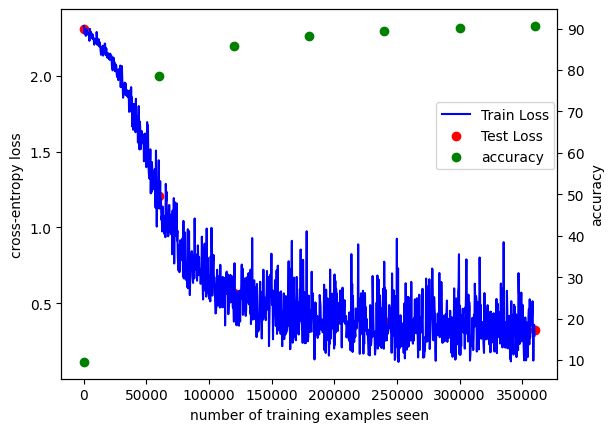

In [6]:
fig, ax = plt.subplots()
ax.plot(train_counter, train_losses, color='blue')
ax.scatter(test_counter, test_losses, color='red')

plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
ax2 = ax.twinx()
ax2.scatter(test_counter, test_accuracy, color='green')
#ax2.legend(['accuracy'], loc='center left')
ax2.set_ylabel('accuracy')
ax2.yaxis.set_label_position('right')
fig.legend(['Train Loss', 'Test Loss', 'accuracy'], bbox_to_anchor=(0.7, 0.7), loc='upper left')

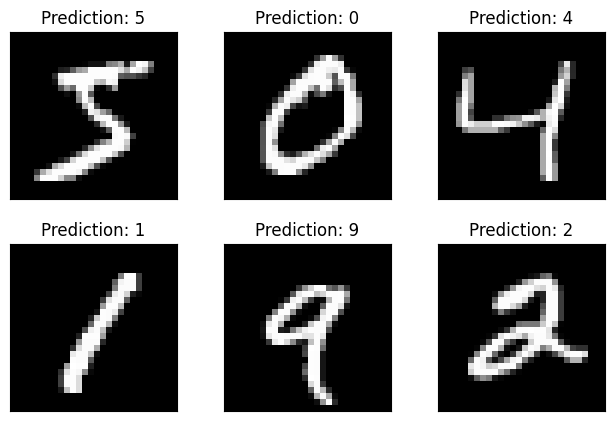

In [7]:
with torch.no_grad():
    output = network(exampleData)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

### Random toys

- [playground.tensorflow](http://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2&seed=0.12602&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=false)
- [derivitives](https://www.mathsisfun.com/calculus/derivative-plotter.html)
- [partial derivitives](https://www.geogebra.org/m/ptzufvkv)

### Overview

1. Determine what the input data for the model will be
2. Build training dataset
    - inputs & target/label for each sample
3. Determine what type of learning model to use & the structure of it
    - NN, Random Forest, Gradient Boost, etc.
4. Set hyperparameters & run the model over the training set
    - Usually model will process the training set in batches of samples
    - Walk the model down the optimization landscape
5. Determine accuracy of model/function on the so far unused test-set data

### What do you think?

- Ideas on how we could use ML at Brainium
- Questions?


#### ML @Brainium

- What can we use it for?
- Rank game difficulties based on stats
    - Move time, number of undos, etc.
- Group players into catagories
- Determine when & when not to play an ad to maximize player retention
- etc.